# Fraud Detection Case Study: Identifying Credit Card Fraudulent Transactions

In this case study, we will explore a fraud detection problem using a dataset containing information about credit card transactions. The goal is to build a model that can accurately classify transactions as fraudulent or benign based on various features associated with each transaction.

The main objective of this case study is to develop a predictive model that can accurately identify fraudulent credit card transactions based on the provided dataset.

- **step:**	Maps a unit of time in the real world. 1 step = 1 hour of time.
- **Customer:** Unique customer ID associated with each transaction.
- **zipCodeOrigin:** The zip code of the transaction's origin/source.
- **Merchant:** The unique ID of the merchant involved in the transaction.
- **zipMerchant:** The zip code of the merchant.
- **Age:** Categorized age of the customer:
    - 0: <= 18
    - 1: 19-25
    - 2: 26-35
    - 3: 36-45
    - 4: 46-55
    - 5: 56-65
    - 6: > 65
    - U: Unknown
- **Gender:** Gender of the customer:
    - E: Enterprise
    - F: Female
    - M: Male
    - U: Unknown
- **Category:** Category of the purchase.
- **Amount:** The amount of the purchase.
- **Fraud:** Target variable: 1 if transaction is fraudulent, 0 if benign.


#### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, make_scorer, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from pycaret.classification import *
from matplotlib.widgets import Slider

#### Functions

In [2]:
def draw_roc(model, y_test, X_test):
    # Obtain prediction probabilities from the model
    y_probs = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and Area Under the Curve (AUC-ROC)
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    return

### Data Preprocessing

#### Import dataset

In [3]:
# Read csv file
df = pd.read_csv('fraud.csv', sep=',', decimal='.')
df

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,'C1753498738','3','F','28007','M1823072687','28007','es_transportation',20.53,0
594639,179,'C650108285','4','F','28007','M1823072687','28007','es_transportation',50.73,0
594640,179,'C123623130','2','F','28007','M349281107','28007','es_fashion',22.44,0
594641,179,'C1499363341','5','M','28007','M1823072687','28007','es_transportation',14.46,0


#### Null values
Treating null values before training a classification model is essential to ensure data integrity, compatibility with algorithms, and to prevent bias, ultimately leading to more accurate and reliable model performance.

In this case, there aren't any.

In [4]:
# Find missing values
nulls_per_col = df.isnull().sum()
print(nulls_per_col)

# In case there are missing values, drop them
# df = df.dropna()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64


#### Clean our dataframe
In this section, I will clean our DataFrame by removing single quotes from all string values. It is a personal preference.

In [5]:
# Remove single quotes from all string values in a DataFrame
df = df.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)
df

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,F,28007,M1823072687,28007,es_transportation,20.53,0
594639,179,C650108285,4,F,28007,M1823072687,28007,es_transportation,50.73,0
594640,179,C123623130,2,F,28007,M349281107,28007,es_fashion,22.44,0
594641,179,C1499363341,5,M,28007,M1823072687,28007,es_transportation,14.46,0


#### Identifying Duplicate Rows
In this section, I identify and display duplicate rows in our DataFrame. Identifying duplicates is a crucial step in data cleaning, as duplicate entries can skew the results of your analysis and models.

In [6]:
# Find if there are any duplicated rows
duplicados = df[df.duplicated()]
duplicados

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud


#### Variable analysis

In this section, I will determine the number of unique values for each variable in our DataFrame. This helps in understanding the distribution and variability of data across different columns. 

If certain columns have unique values for every row, they may not be relevant for analysis and can be removed.

In [7]:
# Show how many unique values are there for each variables
for col in df.columns: 
    print(f'{col}: {len(df[col].unique())}')
    
# Variables zipcodeOri and zipMerchant have unique values, therefore theya re not relevant. 
print('\nzipcodeOri', df['zipcodeOri'].unique())
print('zipMerchant', df['zipMerchant'].unique())

# Delte from dataset
df = df.drop(columns=['zipMerchant', 'zipcodeOri'])

step: 180
customer: 4112
age: 8
gender: 4
zipcodeOri: 1
merchant: 50
zipMerchant: 1
category: 15
amount: 23767
fraud: 2

zipcodeOri ['28007']
zipMerchant ['28007']


### Exploratory Data Analysis (EDA)

#### Calculating and Visualizing the Distribution of the Target Variable (Fraud)
In this section, we will calculate the distribution of the target variable, fraud, in terms of both absolute and relative frequencies. We will also visualize this distribution using a bar plot.

Frequency table:
fraud
0    587443
1      7200

Relative Frequency table (%):
fraud
0    98.79
1     1.21


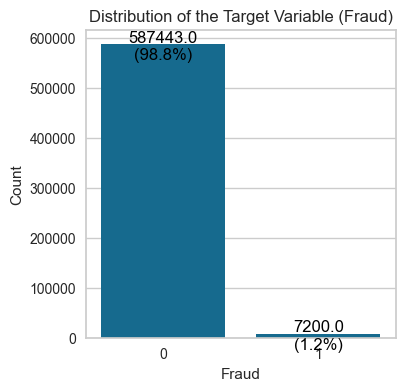

In [8]:
# Calculate the distribution
fraud_distribution = df['fraud'].value_counts()
total_count = len(df['fraud'])
fraud_distribution_rel = round(100 * fraud_distribution / total_count, 2)

# Print in a nicer format
print("Frequency table:")
print(fraud_distribution.to_string())
print("\nRelative Frequency table (%):")
print(fraud_distribution_rel.to_string())

# Plot the distribution
plt.figure(figsize=(4, 4))
ax = sns.countplot(x='fraud', data=df)
plt.title('Distribution of the Target Variable (Fraud)')
plt.xlabel('Fraud')
plt.ylabel('Count')

# Add total count and percentage text on each bar
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
    ax.annotate(f'\n{p.get_height()}\n({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

#### Normalizing Numeric Variables and Visualizing Relationships
In this section, we will normalize the numeric variable amount using standard scaling to ensure that its values are on a similar scale. Additionally, we will visualize the relationship between the normalized amount feature and the target variable fraud.

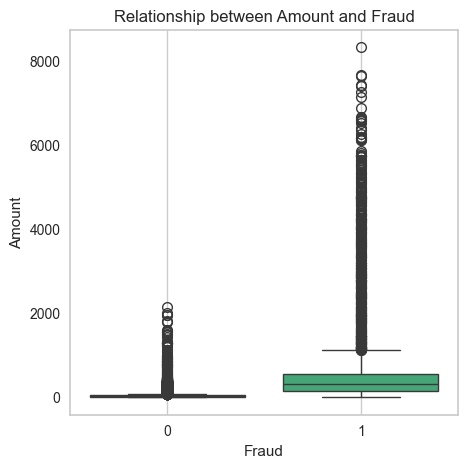

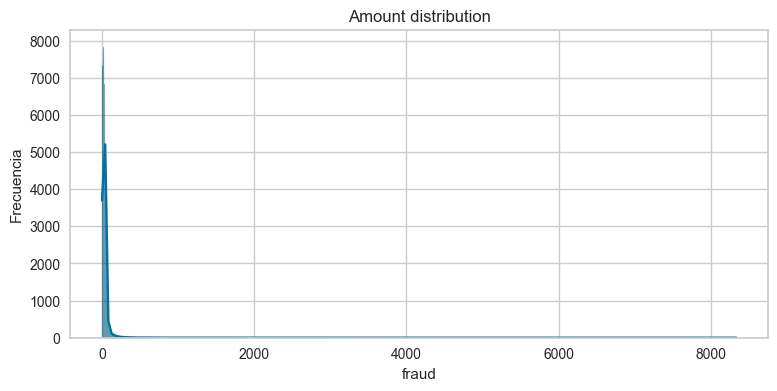

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,-0.299276,0
1,0,C352968107,2,M,M348934600,es_transportation,0.016067,0
2,0,C2054744914,4,F,M1823072687,es_transportation,-0.098742,0
3,0,C1760612790,3,M,M348934600,es_transportation,-0.185275,0
4,0,C757503768,5,M,M348934600,es_transportation,-0.019480,0
...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,F,M1823072687,es_transportation,-0.155832,0
594639,179,C650108285,4,F,M1823072687,es_transportation,0.115256,0
594640,179,C123623130,2,F,M349281107,es_fashion,-0.138687,0
594641,179,C1499363341,5,M,M1823072687,es_transportation,-0.210319,0


In [9]:
# Visualize the Relationship Between the Numeric Feature (amount) and the Target Variable (fraud)
plt.figure(figsize=(5, 5))
sns.boxplot(x='fraud', y='amount', data=df, palette='viridis')
plt.title('Relationship between Amount and Fraud')
plt.xlabel('Fraud')
plt.ylabel('Amount')
plt.grid()
plt.show()

plt.figure(figsize=(9, 4))
sns.histplot(df['amount'], kde=True)
plt.title(f'Amount distribution')
plt.xlabel(col)
plt.ylabel('Frecuencia')
plt.show()

# The numeric variables should be normalizsed
scaler = StandardScaler()
df['amount'] = scaler.fit_transform(df[['amount']])
df

#### Visualizing Relationships Between Categorical Features and Fraud

In this section, we will visualize the relationship between categorical features and the target variable fraud. We will define the categorical features and specify the color palette for visualization.

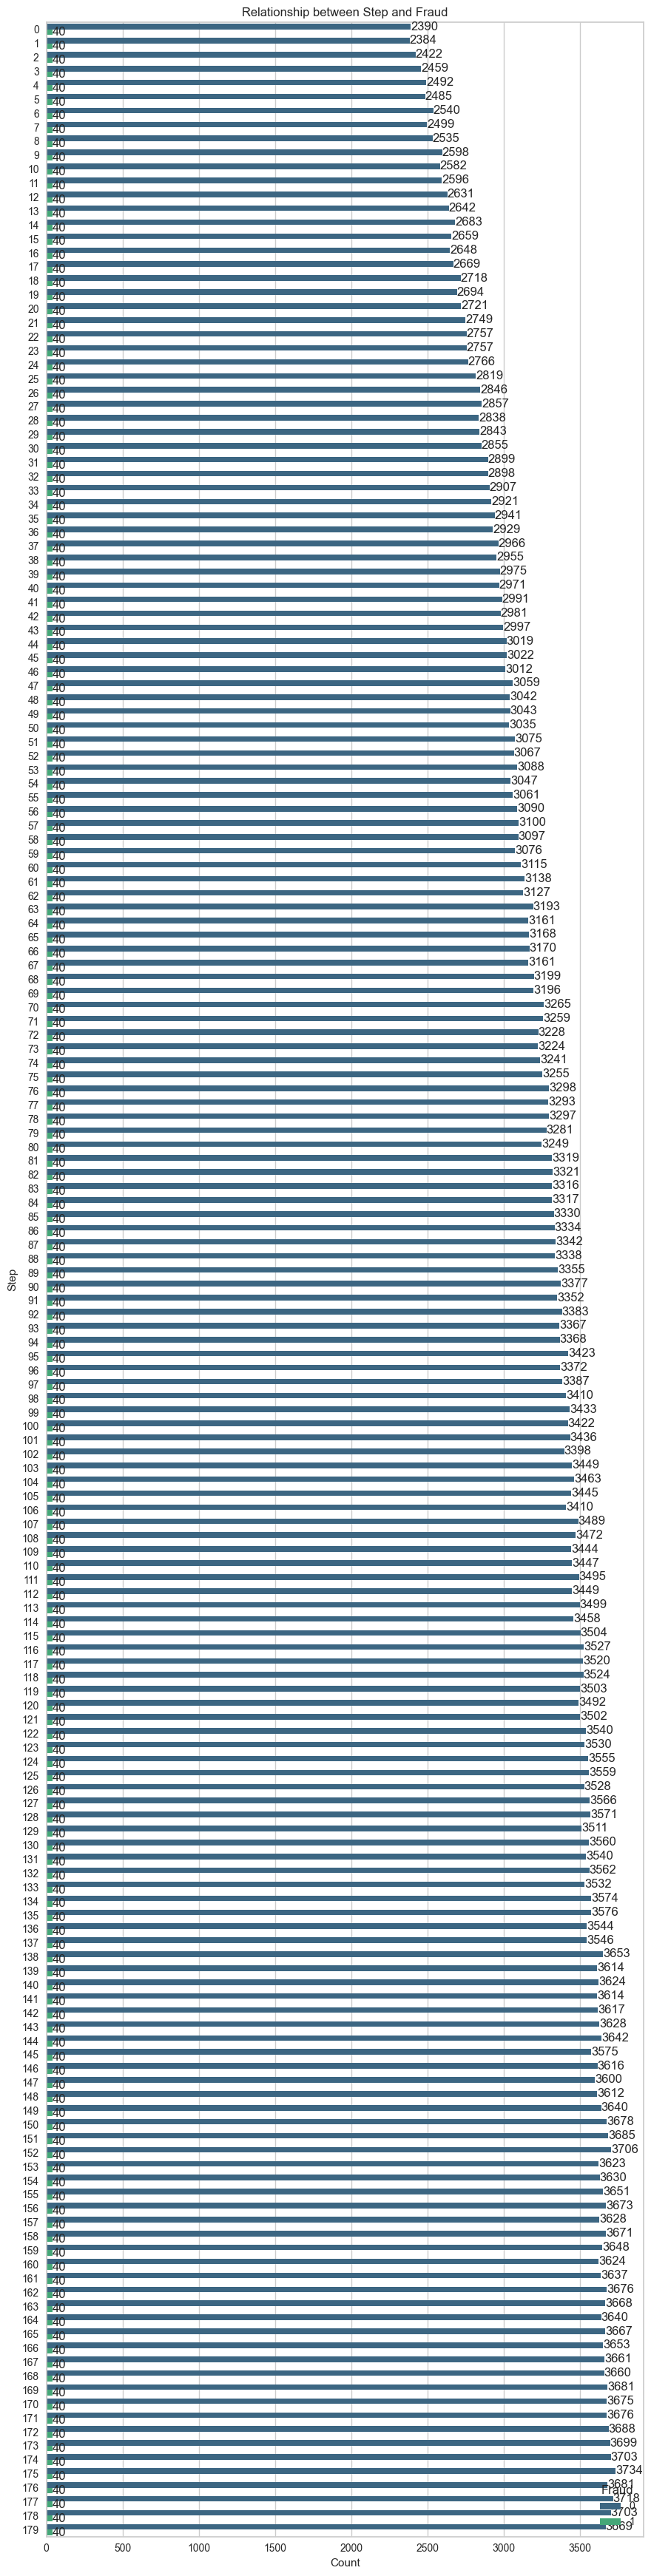

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#categorical_features = ['age', 'gender', 'merchant', 'category']
categorical_features = ['step']

for feature in categorical_features:
    plt.figure(figsize=(9, 35))
    graph = sns.countplot(y=feature, hue='fraud', data=df.sort_values(['age'], ascending=True), palette='viridis', orient='h')
    graph.bar_label(graph.containers[0])
    graph.bar_label(graph.containers[1])
    plt.title(f'Relationship between {feature.capitalize()} and Fraud')
    plt.ylabel(feature.capitalize())
    plt.xlabel('Count')
    plt.legend(title='Fraud', loc='lower right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


### Model selection

The code conducts preprocessing steps for machine learning. It encodes categorical variables utilizing LabelEncoder and executes one-hot encoding. The dataset is partitioned into training and testing sets with an 80-20 ratio. Features are stored in X_train and X_test, while the target variable 'fraud' is stored in y_train and y_test.

In [12]:
# Load your data
data = df

# Select the features and the target variable
X = data.drop('fraud', axis=1)
y = data[['fraud']]

# Perform one-hot encoding for 'age', 'gender', and 'category' columns
X = pd.get_dummies(X, columns=['age', 'gender', 'category'])

# Encode 'merchant' and 'customer' columns
label_encoder = LabelEncoder()
X['merchant'] = label_encoder.fit_transform(X['merchant'])
X['customer'] = label_encoder.fit_transform(X['customer'])

# Convert categorical variables to type 'category'
categorical_features = ['customer', 'merchant', 'step']
for col in categorical_features:
    X[col] = X[col].astype('category')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### XGBoost

The results of the XGBoost model are impressive, achieving near-perfect performance metrics across the board. However, it's important to consider the class imbalance issue in the dataset, where only 1.2% of the samples belong to class '1'. Despite this imbalance, the model demonstrates high accuracy, precision, and recall for the minority class ('1'). This suggests that the model is effectively capturing patterns associated with the minority class.

[0]	validation_0-logloss:0.10686
[1]	validation_0-logloss:0.07971
[2]	validation_0-logloss:0.06045
[3]	validation_0-logloss:0.04652
[4]	validation_0-logloss:0.03645
[5]	validation_0-logloss:0.02907
[6]	validation_0-logloss:0.02371
[7]	validation_0-logloss:0.01975
[8]	validation_0-logloss:0.01683
[9]	validation_0-logloss:0.01466
[10]	validation_0-logloss:0.01312
[11]	validation_0-logloss:0.01196
[12]	validation_0-logloss:0.01111
[13]	validation_0-logloss:0.01049
[14]	validation_0-logloss:0.01003
[15]	validation_0-logloss:0.00969
[16]	validation_0-logloss:0.00941
[17]	validation_0-logloss:0.00923
[18]	validation_0-logloss:0.00911
[19]	validation_0-logloss:0.00900
[20]	validation_0-logloss:0.00895
[21]	validation_0-logloss:0.00893
[22]	validation_0-logloss:0.00889
[23]	validation_0-logloss:0.00885
[24]	validation_0-logloss:0.00882
[25]	validation_0-logloss:0.00881
[26]	validation_0-logloss:0.00881
[27]	validation_0-logloss:0.00882
[28]	validation_0-logloss:0.00883
[29]	validation_0-loglos

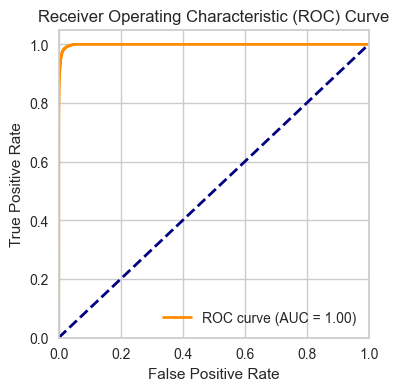

In [13]:
# Create and train the XGBoost model
XGB_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,  # Deactivate label encoding to avoid the warning
    enable_categorical=True  # Enable automatic handling of categorical features
)

XGB_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=True)

# Make predictions
y_pred = XGB_model.predict(X_test)

# Evaluate model performance
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy score:")
print(accuracy_score(y_test, y_pred))

# Draw AUC_ROC
draw_roc(XGB_model, y_test, X_test)

#### Random forest
The random forest model demonstrates strong performance metrics, achieving high accuracy, precision, and recall. However, compared to the XGBoost model, it shows slightly lower recall for the minority class ('1'), indicating it may not be as effective at capturing all instances of fraud. Nevertheless, the model still maintains excellent overall performance, with an accuracy score of 99.6% and an AUC-ROC score of 0.99, indicating robustness in distinguishing between positive and negative classes.

Confusion matrix:
[[117383    129]
 [   332   1085]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117512
           1       0.89      0.77      0.82      1417

    accuracy                           1.00    118929
   macro avg       0.95      0.88      0.91    118929
weighted avg       1.00      1.00      1.00    118929


Accuracy score:
0.9961237376922365


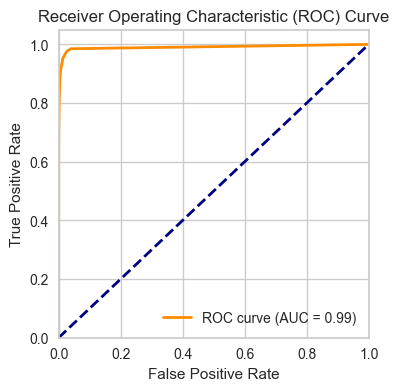

In [14]:
# Create and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy score:")
print(accuracy_score(y_test, y_pred))

# Draw AUC_ROC
draw_roc(rf_model, y_test, X_test)

#### Logistic regression

The logistic regression model exhibits strong performance metrics, with high accuracy, precision, and recall. However, similar to the random forest model, it demonstrates lower recall for the minority class ('1'), indicating potential difficulty in capturing all instances of fraud. Nonetheless, the model maintains excellent overall performance, achieving an accuracy score of 99% and an AUC-ROC score of 0.99, suggesting robustness in distinguishing between positive and negative classes.

Confusion matrix:
[[117436     76]
 [   569    848]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117512
           1       0.92      0.60      0.72      1417

    accuracy                           0.99    118929
   macro avg       0.96      0.80      0.86    118929
weighted avg       0.99      0.99      0.99    118929


Accuracy score:
0.9945765961203743


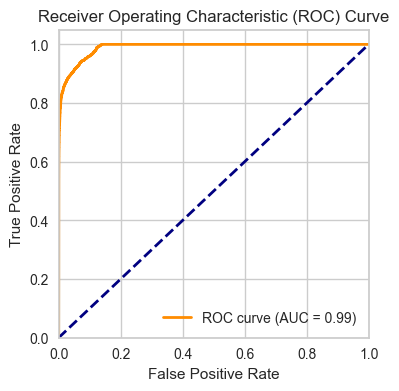

In [15]:
# Create and train the model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate model performance
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy score:")
print(accuracy_score(y_test, y_pred))

# Draw AUC_ROC
draw_roc(lr_model, y_test, X_test)

#### Balanced Logistic regression

The logistic regression model with balanced class weights exhibits contrasting performance metrics compared to the previous models. While achieving a high recall for the minority class ('1'), it sacrifices precision, resulting in a lower overall accuracy. This indicates that the model is effective at identifying instances of fraud but may also classify some non-fraudulent transactions as fraudulent. Despite this trade-off, the model maintains strong performance with an accuracy score of 93% and an AUC-ROC score of 0.99, demonstrating its ability to distinguish between positive and negative classes.

In [ ]:
# Create and train the model
lr2_model = LogisticRegression(class_weight='balanced')
lr2_model.fit(X_train, y_train)

# Make predictions
y_pred = lr2_model.predict(X_test)

# Evaluate model performance
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy score:")
print(accuracy_score(y_test, y_pred))

# Draw AUC_ROC
draw_roc(lr2_model, y_test, X_test)

#### SVM
The Support Vector Machine (SVM) model exhibits strong performance metrics, achieving high accuracy, precision, and recall. However, similar to other models, it demonstrates lower precision for the minority class ('1'), suggesting it may misclassify some non-fraudulent transactions as fraudulent. Nonetheless, the model maintains excellent overall performance, with an accuracy score of 98.9%. The classification report indicates that the model has high recall for the minority class, indicating its effectiveness in identifying instances of fraud. Despite the longer execution time exceeding 40 minutes, the SVM model showcases robustness in distinguishing between positive and negative classes.

In [ ]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Inicializar el modelo SVM con penalización por clase desequilibrada
class_weight = {0: 1, 1: 10}
svm_model = SVC(kernel='rbf', class_weight=class_weight)
svm_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = svm_model.predict(X_test)

# Evaluar el rendimiento del modelo
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy score:")
print(accuracy_score(y_test, y_pred))


#### Neural Networks

The neural network model demonstrates strong performance metrics, achieving high accuracy, precision, and recall. However, compared to other models, it shows slightly lower recall for the minority class ('1'), indicating it may not be as effective at capturing all instances of fraud. Nonetheless, the model maintains excellent overall performance, with an accuracy score of 99.5% and an AUC-ROC score of 1, suggesting robustness in distinguishing between positive and negative classes.

In [ ]:
# Create and train the model
nn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
nn_model.fit(X_train, y_train)

# Make predictions
y_pred = nn_model.predict(X_test)

# Evaluate model performance
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy score:")
print(accuracy_score(y_test, y_pred))

# Draw AUC_ROC
draw_roc(nn_model, y_test, X_test)

#### Neural Networks Balanced
The neural network model with SMOTE applied to balance the classes demonstrates notable improvement in performance metrics, particularly in recall for the minority class ('1'). This indicates that SMOTE has effectively addressed the class imbalance issue, leading to better identification of instances of fraud. Despite slightly lower precision compared to other models, the model maintains strong overall performance, with an accuracy score of 97.7%. The classification report shows improved metrics for both precision and recall for the minority class, resulting in a higher F1-score. Overall, the model's performance suggests enhanced robustness in distinguishing between positive and negative classes after applying SMOTE.

### Model optimization

In [ ]:
# Assigning the DataFrame to 'data'
data = df

# Selecting features and the target variable
X = data.drop('fraud', axis=1)
y = data[['fraud']]

# Encoding categorical variables
label_encoder = LabelEncoder()
X['merchant'] = label_encoder.fit_transform(X['merchant'])
X['customer'] = label_encoder.fit_transform(X['customer'])
X = pd.get_dummies(X, columns=['age', 'gender', 'category'])

# Converting categorical variables to 'category' type
categorical_features = ['customer', 'merchant', 'step']
for col in categorical_features:
    X[col] = X[col].astype('category')
    
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the hyperparameters to search
param_grid = {
    'n_estimators': [75],
    'learning_rate': [0.1],
    'max_depth': [5],
    'use_label_encoder': [False],
    'enable_categorical': [True]
}

# Initializing the XGBoost model
xgb_model = XGBClassifier()

# Performing hyperparameter search

f1_scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring=f1_scorer)
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Using the best hyperparameters to train the model
best_xgb_model = XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluate model performance
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy score:")
print(accuracy_score(y_test, y_pred))

# Drawing AUC_ROC
draw_roc(best_xgb_model, y_test, X_test)

In [ ]:
from matplotlib import pyplot
plt.bar(list(X.columns), best_xgb_model.feature_importances_)
plt.xticks(rotation=90)

#### Cross validation

In [ ]:
# Creating an XGBoost classifier with the best hyperparameters found
xgb_model = XGBClassifier(enable_categorical=True, learning_rate=0.1, max_depth=5, n_estimators=75, use_label_encoder=False)

# Performing cross-validation with 5 folds
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring=f1_scorer)

# Printing cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Cross-Validation Score (Average):", np.mean(cv_scores))

___